In [129]:
%matplotlib inline

import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense,LSTM
import matplotlib.pyplot as plt
seed = 7
np.random.seed(seed)

In [130]:
data = pd.read_csv("raw.csv")

In [131]:
data.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [132]:
from datetime import datetime
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')

data = pd.read_csv('raw.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)

In [133]:
data.head()

,No,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
year_month_day_hour,,,,,,,,,
2010-01-01 00:00:00,1,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,2,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,3,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,4,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,5,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [134]:
data = data.drop("No",axis=1)
data.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
data.index.name = 'date'

data['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
data = data[24:]

data.to_csv("pollution.csv")

In [135]:
data.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


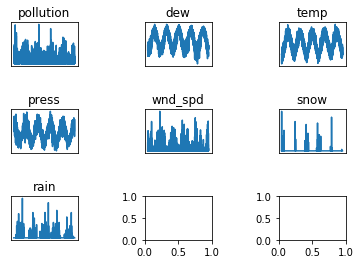

In [136]:
groups = [0, 1, 2, 3, 5, 6, 7]
values = data.values
fig,sub = plt.subplots(3,3)
plt.subplots_adjust(wspace=1, hspace=1)

for ax, i in zip(sub.flatten(),groups):
    ax.plot(values[:,i])
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(data.columns[i])

In [137]:
#preprocess the wind direction with label encoding
from sklearn.preprocessing import LabelEncoder
values = data.values
encoder = LabelEncoder()

values[:,4] = encoder.fit_transform(values[:,4])
values[:,4]

array([2, 2, 2, ..., 1, 1, 1], dtype=object)

In [138]:
#Scale the data

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled = scaler.fit_transform(values)
scaled[0]

array([ 0.12977867,  0.35294118,  0.24590164,  0.52727273,  0.66666667,
        0.00229001,  0.        ,  0.        ])

In [139]:
#convert data to supervised form

def to_supervised(data,dropNa = True):
    df = pd.DataFrame(data)
    column = df.iloc[:,0].shift(-1)
    df["out"] = column
    df.dropna(inplace = True)
    return df.values

In [140]:
supervised = to_supervised(scaled)
pd.DataFrame(supervised).head()

,0,1,2,3,4,5,6,7,8
0,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893
1,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960
2,0.159960,0.426471,0.229508,0.545455,0.666667,0.005332,0.000000,0.0,0.182093
3,0.182093,0.485294,0.229508,0.563636,0.666667,0.008391,0.037037,0.0,0.138833
4,0.138833,0.485294,0.229508,0.563636,0.666667,0.009912,0.074074,0.0,0.109658


In [141]:
# spiltting the data
# training on only first year data

train_hours = 365*24
X = supervised[:,:8]
y = supervised[:,8]

x_train = X[:train_hours,:]
x_test = X[train_hours:,:]
y_train = y[:train_hours]
y_test = y[train_hours:]

print x_train.shape,x_test.shape,y_train.shape,y_test.shape

(8760, 8) (35039, 8) (8760,) (35039,)


In [142]:
#convert data to fit for lstm
#dimensions = (sample, timeSteps here it is 1, features )

x_train = x_train.reshape(x_train.shape[0],1,x_train.shape[1])
x_test = x_test.reshape(x_test.shape[0],1,x_test.shape[1])

print x_train.shape,x_test.shape

(8760, 1, 8) (35039, 1, 8)


In [143]:
#define the model

model = Sequential()
model.add( LSTM( 50, input_shape = ( 1,x_train.shape[2]) ) )
model.add( Dense(1) )

model.compile( loss = "mae", optimizer = "adam")

history =  model.fit( x_train,y_train, validation_data = (x_test,y_test), epochs = 50 , batch_size = 72, verbose = 0, shuffle = False)

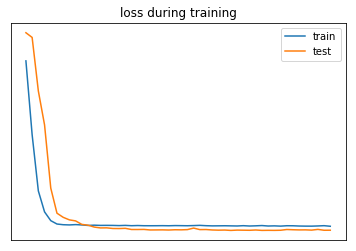

In [189]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.yticks([])
plt.xticks([])
plt.title("loss during training")
plt.show()

In [145]:
#scale back the prediction to orginal scale
y_pred = model.predict(x_test)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[2])

inv_new = np.concatenate( (y_pred, x_test[:,1:] ) , axis =1)
inv_new = scaler.inverse_transform(inv_new)
final_pred = inv_new[:,0]

y_test = y_test.reshape( len(y_test), 1)

inv_new = np.concatenate( (y_test, x_test[:,1:] ) ,axis = 1)
inv_new = scaler.inverse_transform(inv_new)
actual_pred = inv_new[:,0]

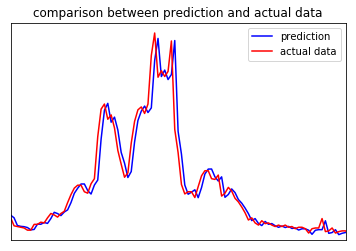

In [188]:
#plot the prediction with actual data

plt.plot(final_pred[:200], label = "prediction",c = "b")
plt.plot(actual_pred[:200],label = "actual data",c="r")
plt.xlim(0, 100)
plt.ylim(0, 300)
plt.yticks([])
plt.xticks([])
plt.title("comparison between prediction and actual data")
plt.legend()

In [182]:
from sklearn.metrics import mean_absolute_error

print ("%f - mean absolute error")%(mean_absolute_error(final_pred,actual_pred) )
print ("%f - mean squared error")%(mean_squared_error(final_pred,actual_pred))

13.311529 - mean absolute error
702.319895 - mean squared error
